In [98]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import scipy.stats as stat
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

Code to Plot histogram

In [115]:
# This plotting code taken from GeeksForGeeks website
def plot_hist(data, num_bins, x_title, y_title, plot_title):
    fig, axs = plt.subplots(1, 1, figsize =(12, 4), tight_layout = True) 
    # Remove axes splines 
    for s in ['top', 'bottom', 'left', 'right']: 
        axs.spines[s].set_visible(False) 
    # Remove x, y ticks
    axs.xaxis.set_ticks_position('none') 
    axs.yaxis.set_ticks_position('none') 
    # Add padding between axes and labels 
    axs.xaxis.set_tick_params(pad = 5) 
    axs.yaxis.set_tick_params(pad = 10) 
    # Add x, y gridlines 
    axs.grid(True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.6) 
    
    # Creating histogram
    N, bins, patches = axs.hist(data, bins = num_bins)
    
    # Setting color
    fracs = ((N**(1 / 5)) / N.max())
    norm = colors.Normalize(fracs.min(), fracs.max())
    
    for thisfrac, thispatch in zip(fracs, patches):
        color = plt.cm.viridis(norm(thisfrac))
        thispatch.set_facecolor(color)
    
    # Adding extra features    
    plt.xlabel(x_title)
    plt.ylabel(y_title)
    # plt.legend("Only Smoking")
    plt.title(plot_title)
    
    # Show plot
    plt.show()

$Data\ Extraction$
---

In [2]:
with open("Raw Data_GeneSpring.txt", 'r') as f:
    lines = f.readlines()

Column_Names = []
for word in lines[0].split():
    Column_Names.append(word)

In [3]:
Male_Non_Smokers = [f"GSM1149{i}_M_Ns{i-106+3}.txt:gProcessedSignal(normalized)" for i in range(106, 117+1)]
Male_Smokers = [f"GSM1149{i}_M_S{'M' if i == 127 else 'm'}{i-118+1 if i <= 123 else i-118+2}.txt:gProcessedSignal(normalized)" for i in range(118, 129+1)]

Female_Non_Smokers = [f"GSM1149{i}_F_Ns{(i-130)*2+1}.txt:gProcessedSignal(normalized)" for i in range(130, 133)]
for i in range(133, 141+1):
    Female_Non_Smokers.append(f"GSM1149{i}_F_Ns{i-130+3}.txt:gProcessedSignal(normalized)")
Female_Smokers = [f"GSM1149{i}_F_Sm{i-142+1}.txt:gProcessedSignal(normalized)" for i in range(142, 153+1)]

Auxiliary_Columns = ["ProbeName", "GeneSymbol", "EntrezGeneID"]

In [4]:
Male_Non_Smokers = [f"Male Non Smoker {i}" for i in range(1, 13, 1)]
Male_Smokers = [f"Male Smoker {i}" for i in range(1, 13, 1)]
Female_Non_Smokers = [f"Female Non Smoker {i}" for i in range(1, 13, 1)]
Female_Smokers = [f"Female Smoker {i}" for i in range(1, 13, 1)]

Columns = ["Name of Gene"] + Male_Non_Smokers + Male_Smokers + Female_Non_Smokers + Female_Smokers
# df = pd.DataFrame(columns=Columns)

In [5]:
# for line in tqdm(lines[3:]):
#     row = line.split()[0 : 49]
#     values = [row[0]] + [np.exp(float(x)) for x in row[1 : 49]]
#     df.loc[len(df)] = values

In [6]:
# df.to_csv("GeneData.csv", index=False)

In [7]:
myDataFrame = pd.read_csv("GeneData.csv")

In [8]:
print(myDataFrame.head())

   Name of Gene  Male Non Smoker 1  Male Non Smoker 2  Male Non Smoker 3  \
0   A_24_P66027      155524.102719      118375.730318      137527.475783   
1   A_32_P77178         504.968676        1057.692894        1208.324538   
2  A_23_P212522       11250.152915        9551.925154        7589.408987   
3  A_24_P934473         883.660554         876.760618         799.635821   
4    A_24_P9671       75462.490710      175218.930071      151963.098906   

   Male Non Smoker 4  Male Non Smoker 5  Male Non Smoker 6  Male Non Smoker 7  \
0      211693.764019       75653.955145      123281.051584      107221.492794   
1        1510.012639         743.385684         862.995089        2466.368241   
2        9569.354196        9657.991632        6703.271703       42865.303438   
3         503.199796         373.711235         502.515457        7153.049155   
4      347389.879416      101052.049029      177194.273493      848449.631433   

   Male Non Smoker 8  Male Non Smoker 9  ...  Female Smo

$Working\ On\ Data$
---

In [37]:
Null_Hypothesis = pd.DataFrame(columns=Columns + ["P Value (Smoke)", "P Value (Gender)", "P Value (Smoke + Gender)"])

In [40]:
All_Column_Values = Male_Non_Smokers + Male_Smokers + Female_Non_Smokers + Female_Smokers
List_of_Groups = [Male_Non_Smokers , Male_Smokers , Female_Non_Smokers , Female_Smokers]

deg_freedom_Gender = 2 - 1
deg_freedom_Cigar = 2 - 1
deg_freedom_Within = 4 * (12 - 1)
deg_freedom_Both = deg_freedom_Gender * deg_freedom_Cigar
deg_freedom_Total = deg_freedom_Gender + deg_freedom_Cigar + deg_freedom_Within + deg_freedom_Both

Cut_Off = 0.05

for index, row in tqdm(myDataFrame.iterrows()):

    gene_name = row["Name of Gene"]

    M_NS_mean = np.mean(row[Male_Non_Smokers])
    M_S_mean = np.mean(row[Male_Smokers])
    F_NS_mean = np.mean(row[Female_Non_Smokers])
    F_S_mean = np.mean(row[Female_Smokers])

    NS_mean = (M_NS_mean + F_NS_mean) / 2.0
    S_mean = (M_S_mean + F_S_mean) / 2.0
    F_mean = (F_NS_mean + F_S_mean) / 2.0
    M_mean = (M_NS_mean + M_S_mean) / 2.0

    global_mean = (M_mean + F_mean) / 2.0

    sum_of_sq_Gender = 12 * (((global_mean - M_mean) ** 2) + ((global_mean - F_mean) ** 2))
    sum_of_sq_Cigar = 24 * (((global_mean - S_mean) ** 2) + ((global_mean - NS_mean) ** 2)) 
    sum_of_sq_Within = 12 * (np.var(row[Male_Non_Smokers]) + np.var(row[Male_Smokers]) + np.var(row[Female_Non_Smokers]) + np.var(row[Female_Smokers]))
    sum_of_sq_Total = 48 * (np.var(row[All_Column_Values]))
    sum_of_sq_Both = sum_of_sq_Total - sum_of_sq_Gender - sum_of_sq_Cigar - sum_of_sq_Within

    mean_sq_Gender = sum_of_sq_Gender / deg_freedom_Gender
    mean_sq_Cigar = sum_of_sq_Cigar / deg_freedom_Cigar
    mean_sq_Within = sum_of_sq_Within / deg_freedom_Within
    mean_sq_Both = sum_of_sq_Both / deg_freedom_Both
    if(mean_sq_Both == 0 or mean_sq_Cigar == 0 or mean_sq_Gender == 0 or mean_sq_Within == 0):
        continue
    
    #F-Distribution = F(deg_freedom gender/cigar/both, deg_freedom_within) = F_Score
    # from Chi-Square, get F(x, k) for p < 0.05. If F_score > F(x, k) for p < 0.05, reject null hypothesis
    # Rejecting Null Hypothesis means that the factor DOES have significant effect. Yessss, huge effect
    # We can calculate exact p-value using SPSS. If exact p-value < 0.05, then reject null hypothesis
    # If exact p-value is < 0.05 then Gender/Cigar has effect
    # If exact p-value is > 0.05 then Gender/Cigar does not have effect
    F_Score_Gender = mean_sq_Gender / mean_sq_Within  
    F_Score_Cigar = mean_sq_Cigar / mean_sq_Within
    F_Score_Both = mean_sq_Both / mean_sq_Within

    Exact_p_Gender = 1 - stat.f.cdf(F_Score_Gender, deg_freedom_Gender, deg_freedom_Within)
    Exact_p_Cigar = 1 - stat.f.cdf(F_Score_Cigar, deg_freedom_Cigar, deg_freedom_Within)
    Exact_p_Both = 1 - stat.f.cdf(F_Score_Both, deg_freedom_Both, deg_freedom_Within)

    row["P Value (Smoke)"] = Exact_p_Cigar
    row["P Value (Gender)"] = Exact_p_Gender
    row["P Value (Smoke + Gender)"] = Exact_p_Both

    Null_Hypothesis.loc[len(Null_Hypothesis)] = row

41091it [1:16:34,  8.94it/s]


In [41]:
Null_Hypothesis.to_csv("Calculated P Values.csv", index=False)

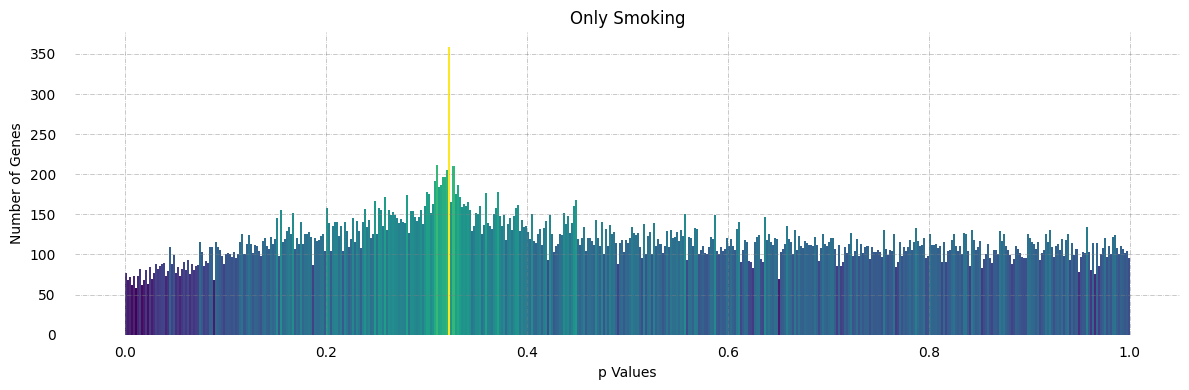

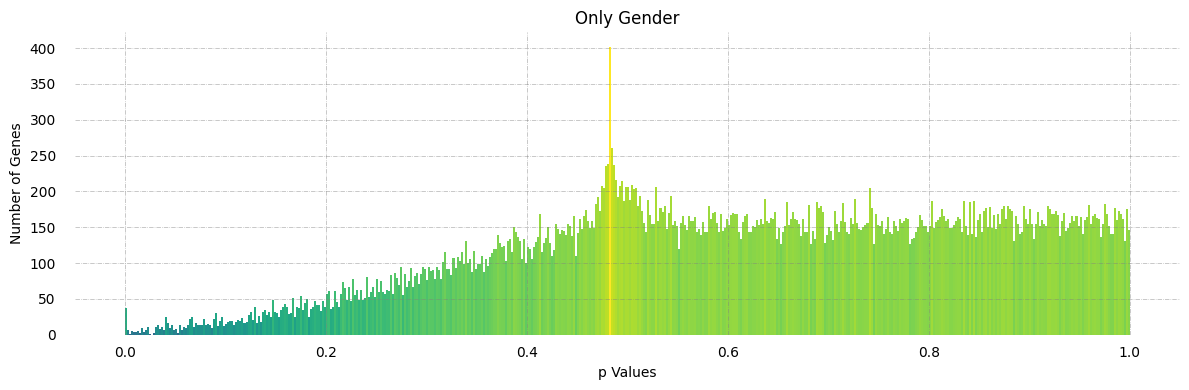

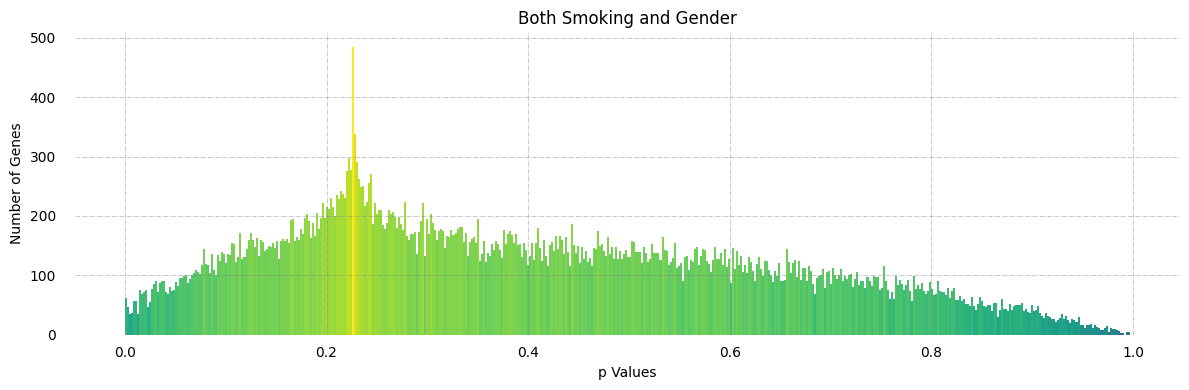

In [117]:
plot_hist(Null_Hypothesis["P Value (Smoke)"], num_bins=500, x_title="p Values", y_title="Number of Genes", plot_title="Only Smoking")
plot_hist(Null_Hypothesis["P Value (Gender)"], num_bins=500, x_title="p Values", y_title="Number of Genes", plot_title="Only Gender")
plot_hist(Null_Hypothesis["P Value (Smoke + Gender)"], num_bins=500, x_title="p Values", y_title="Number of Genes", plot_title="Both Smoking and Gender")